<a href="https://colab.research.google.com/github/DiegoJarquin/Tensorflow/blob/master/Lab4CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions

import os
import numpy as np
import PIL.Image as Image
import matplotlib.pylab as plt


seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)

In [0]:
from google.colab import files
files.upload()


Saving cookies.txt to cookies.txt


{'cookies.txt': b'# HTTP Cookie File downloaded with cookies.txt by Genuinous @genuinous\n# This file can be used by wget, curl, aria2c and other standard compliant tools.\n# Usage Examples:\n#   1) wget -x --load-cookies cookies.txt "https://www.kaggle.com/kmader/food41"\n#   2) curl --cookie cookies.txt "https://www.kaggle.com/kmader/food41"\n#   3) aria2c --load-cookies cookies.txt "https://www.kaggle.com/kmader/food41"\n#\nwww.kaggle.com\tFALSE\t/\tTRUE\t0\tCSRF-TOKEN\tCfDJ8LdUzqlsSWBPr4Ce3rb9VL8HpIFWVz88j3L_ElHcEc9ZKUKEa3vJ6SnvFmGltxHQGGCWK49ZoyiFwW1_mVqo0DIExuhntS6xglo5L-ESpLQjca56qYXjo4CMCWv9X2lmgSLMcmkTH30APE5egIKwaZc\nwww.kaggle.com\tFALSE\t/\tFALSE\t0\tGCLB\tCMzLrbf6m8LLxQE\n.kaggle.com\tTRUE\t/\tFALSE\t1644259706\t_ga\tGA1.2.1318759777.1581187181\n.kaggle.com\tTRUE\t/\tFALSE\t1581274106\t_gid\tGA1.2.1186620215.1581187181\nwww.kaggle.com\tFALSE\t/\tFALSE\t1596946543\tka_sessionid\t9bf63171b94538f296b6fb01cb4570b701b505be\nwww.kaggle.com\tFALSE\t/\tFALSE\t1596911998\tACCEPTED_

In [0]:
!wget -x --load-cookies cookies.txt "https://www.kaggle.com/moltean/fruits/download" -O data.zip
!unzip data.zip

In [0]:
os.listdir('brain_tumor_dataset')


['yes', 'no']

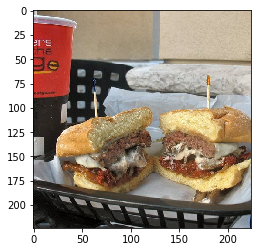

In [25]:
img = image.load_img('training/food/1.jpg', target_size = (224, 224))

plt.imshow(img)

img = image.img_to_array(img)

img = np.expand_dims(img, axis=0)

img = preprocess_input(img)



In [27]:
train_im = os.path.dirname('training/')
valid_im = os.path.dirname('validation/')

train_food_im = os.path.dirname('training/food/')
train_nfood_im = os.path.dirname('training/non_food/')

valid_food_im = os.path.dirname('validation/food/')
valid_nfood_im = os.path.dirname('validation/non_food/')

num_train_food = len(os.listdir(train_food_im))
num_train_nfood = len(os.listdir(train_nfood_im))

num_valid_food = len(os.listdir(valid_food_im))
num_valid_nfood = len(os.listdir(valid_nfood_im))


total_train = num_train_food + num_train_nfood
total_valid = num_valid_food + num_valid_nfood

print("Total Training Images",total_train)
print("Total Validation Images",total_valid)

print("Total food Images",num_train_food)

Total Training Images 3000
Total Validation Images 1000
Total food Images 1500


In [0]:
epochs = 15
batch_size = 128
IMAGE_SIZE = (150, 150)
CLASS_NAMES = ['food','not_food']

In [0]:
train_im_gen = ImageDataGenerator(rescale=1./255)
valid_im_gen = ImageDataGenerator(rescale=1./255)

In [33]:
train_data_gen = train_im_gen.flow_from_directory(batch_size=batch_size,
                                                           directory=train_im,
                                                           shuffle=True,
                                                           target_size=IMAGE_SIZE,
                                                           class_mode='binary')

Found 3000 images belonging to 2 classes.


In [34]:
valid_data_gen = valid_im_gen.flow_from_directory(batch_size=batch_size,
                                                              directory=valid_im,
                                                              target_size=IMAGE_SIZE,
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


In [35]:
train_batch, labels_batch = next(train_data_gen)
train_batch.shape, labels_batch.shape

((128, 150, 150, 3), (128,))

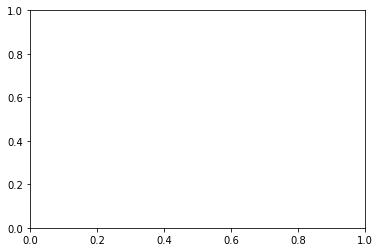

In [55]:
def plot_accuracy_and_loss(history, acc_ylim=[min(plt.ylim()),1.0], loss_ylim=[0,2.0]):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim(acc_ylim)
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim(loss_ylim)
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

def train(m, train_data=train_data_gen, epochs=epochs):
  return m.fit(
            train_data,
            steps_per_epoch=total_train // batch_size,
            epochs=epochs,
            validation_data=valid_data_gen,
            validation_steps=total_valid // batch_size
          )

In [0]:
def plot_images(img_batch, labels=None):
  range_count = 15 if len(img_batch) > 15 else len(img_batch)
  plt.figure(figsize=(12,12))
  for i in range(range_count):
    plt.subplot(4,5,i+1) 
    plt.imshow(img_batch[i])
    if (labels is not None):
      plt.title(CLASS_NAMES[np.int(labels[i])]) 
    plt.axis('off')

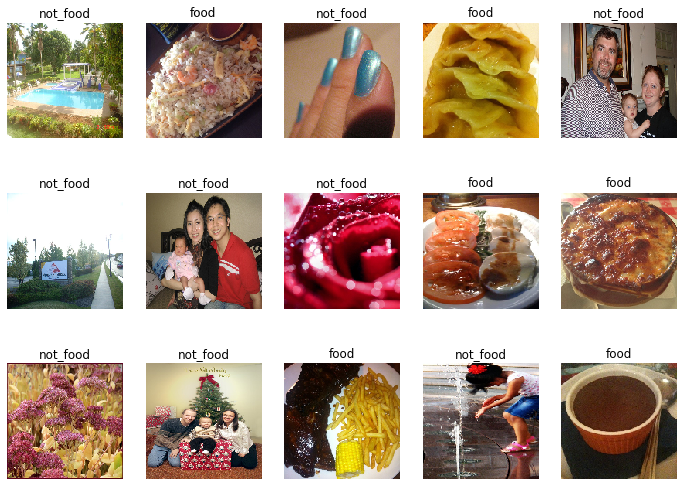

In [38]:
plot_images(train_batch, labels_batch)

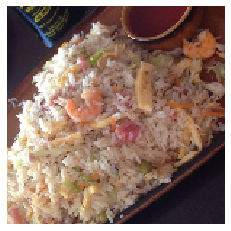

In [41]:
img = train_batch[1]
plt.axis('off')
plt.imshow(img)

In [0]:
def plot_filters(layer):
    filters = layer.shape[3]

    columns = 8
  
    plt.figure(figsize=(20,20))    
    for i in range(filters):
      plt.subplot(columns, columns, i+1)
      plt.title('Filter ' + str(i), color='white')
      plt.axis('off')
      plt.imshow(layer[0,:,:,i], interpolation="nearest", cmap="gray")

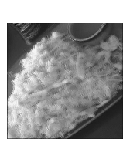

In [43]:
conv = Conv2D(1, 3, padding='same', input_shape=IMAGE_SIZE+(3,))
out = conv(tf.expand_dims(img, 0))
plot_filters(out.numpy())

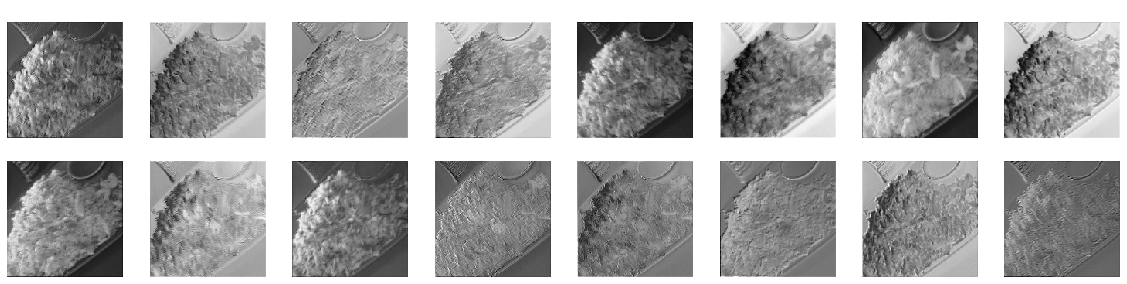

In [44]:
conv = Conv2D(16, 3, padding='same', input_shape=IMAGE_SIZE+(3,))
out = conv(tf.expand_dims(img, 0))
plot_filters(out.numpy())

In [0]:
model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', input_shape=IMAGE_SIZE+(3,)),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [47]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 18, 18, 256)       2

In [0]:
def plot_model_filters(layers, img):
  input = tf.expand_dims(img, 0)
  for filter_layer in layers:
    output = filter_layer(input)    
    input = output
    print(filter_layer)
    plot_filters(output.numpy())
  return


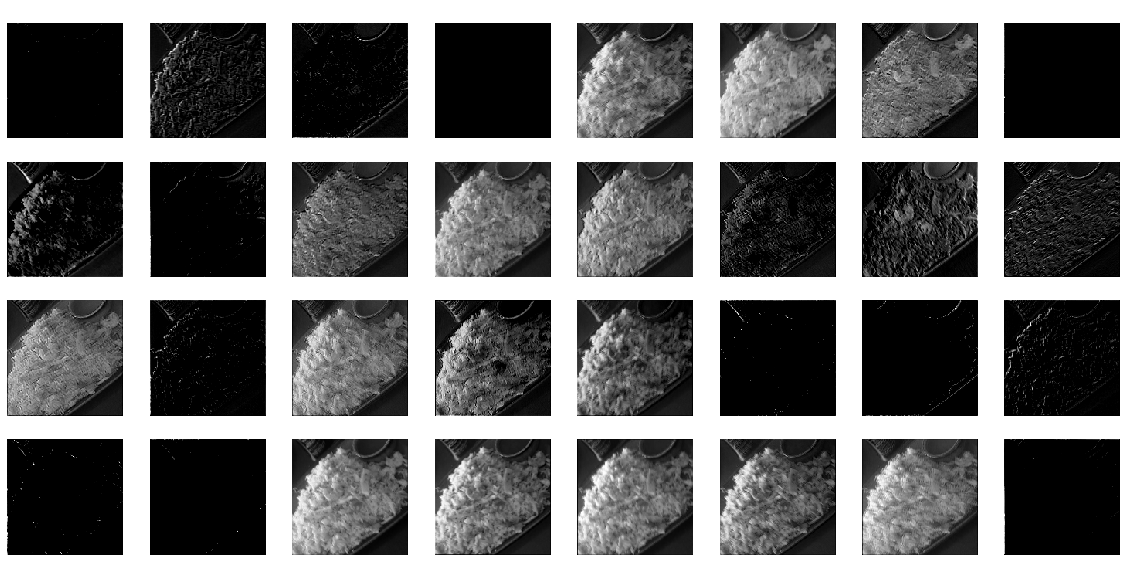

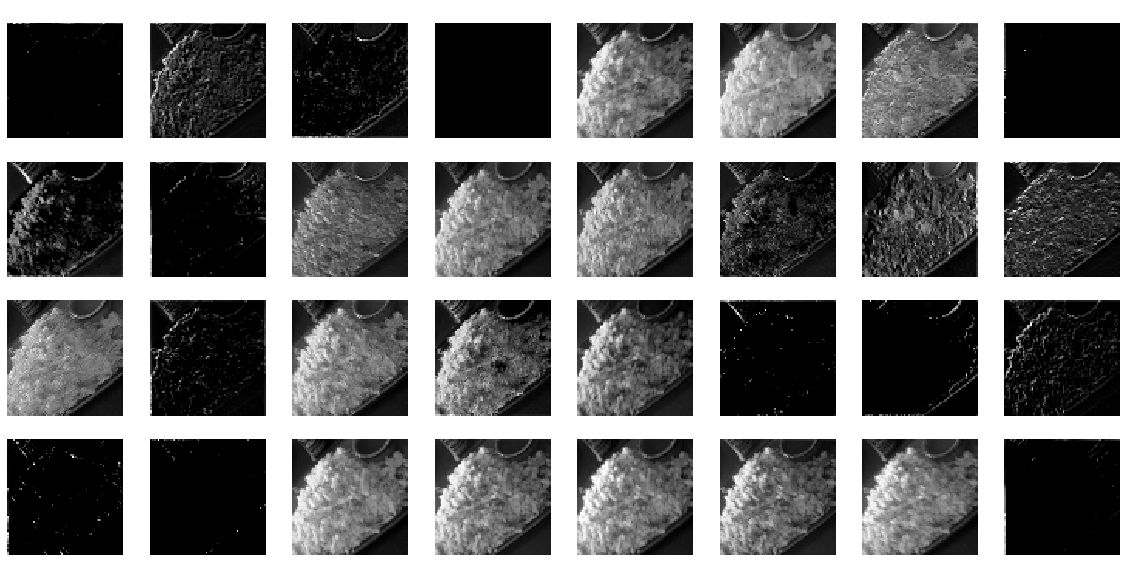

In [49]:
plot_model_filters(model.layers[:2], img)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 23 steps, validate for 7 steps
Epoch 1/15
23/23 [==============================] - 197s 9s/step - loss: 0.6968 - accuracy: 0.5933 - val_loss: 0.5340 - val_accuracy: 0.7221
Epoch 2/15
23/23 [==============================] - 191s 8s/step - loss: 0.4711 - accuracy: 0.7786 - val_loss: 0.4376 - val_accuracy: 0.8125
Epoch 3/15
23/23 [==============================] - 190s 8s/step - loss: 0.3867 - accuracy: 0.8318 - val_loss: 0.3287 - val_accuracy: 0.8627
Epoch 4/15
23/23 [==============================] - 189s 8s/step - loss: 0.3715 - accuracy: 0.8353 - val_loss: 0.3111 - val_accuracy: 0.8783
Epoch 5/15
23/23 [==============================] - 190s 8s/step - loss: 0.2968 - accuracy: 0.8733 - val_loss: 0.2708 - val_accuracy: 0.8951
Epoch 6/15
23/23 [==============================] - 194s 8s/step - loss: 0.2507 - accuracy: 0.8957 - val_loss: 0.3055 - val_accuracy: 0.8783
Epoch 7/15
23/23 [==============================] - 189s 8s/ste

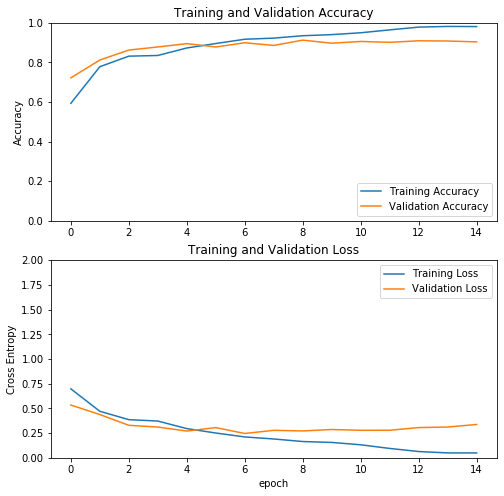

In [56]:
history = train(model)
plot_accuracy_and_loss(history)